In [7]:
import argparse
import logging
import math
import os
import random
import shutil
from pathlib import Path
# import sys
# sys.path.append("../..")

import accelerate
import datasets
import numpy as np
import torch
import torch.nn.functional as F
import torch.autograd.functional as A
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.state import AcceleratorState
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from transformers.utils import ContextManagers

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from diffusers.utils import check_min_version, deprecate, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

from eval import compute_fid, compute_ppl
def deepspeed_zero_init_disabled_context_manager():
        """
        returns either a context list that includes one that will disable zero.Init or an empty context list
        """
        deepspeed_plugin = AcceleratorState().deepspeed_plugin if accelerate.state.is_initialized() else None
        if deepspeed_plugin is None:
            return []

        return [deepspeed_plugin.zero3_init_context_manager(enable=False)]
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.state import AcceleratorState
from accelerate.utils import ProjectConfiguration, set_seed
accelerator = Accelerator(
        gradient_accumulation_steps=1,
        mixed_precision="fp16"
    )
with ContextManagers(deepspeed_zero_init_disabled_context_manager()):
    text_encoder = CLIPTextModel.from_pretrained(
        "stabilityai/stable-diffusion-2", subfolder="text_encoder", revision=None
    )
    vae = AutoencoderKL.from_pretrained(
        "stabilityai/stable-diffusion-2", subfolder="vae", revision=None
    )

unet = UNet2DConditionModel.from_pretrained(
    "stabilityai/stable-diffusion-2", subfolder="unet", revision=None
)
tokenizer = CLIPTokenizer.from_pretrained(
       "stabilityai/stable-diffusion-2", subfolder="tokenizer", revision=None
    )

In [7]:
vae = vae.to("cuda")

In [151]:
import torchvision
topil = transforms.ToPILImage(mode='RGB')
img1_path = "/data/dataset/atd_12k/datasets/test_2k_540p/Disney_v4_1_002812_s2/frame1.png"
img2_path = "/data/dataset/atd_12k/datasets/test_2k_540p/Disney_v4_1_002812_s2/frame3.png"

img1 = torchvision.io.read_image(img1_path)
img2 = torchvision.io.read_image(img2_path)
# img = (torch.stack([img1, img2]).cuda() / 255. * 2. - 1.).to(torch.float32)
img = torch.stack([img1, img2]).cuda() / 255.
# img = (torch.stack([img1, img2]).cuda())
T = transforms.Resize((512,512))
N = transforms.Normalize([0.5], [0.5])
uN = transforms.Normalize(
    mean=[-0.5/0.5],
    std=[1/0.5]
)
img = N(T(img))

In [152]:
with torch.autocast("cuda"):
    with torch.no_grad():
        z = vae.encode(img).latent_dist.sample()

In [153]:
zh = torch.lerp(z[0],z[1],0.5)

In [161]:
from torchvision.transforms.functional import to_pil_image
with torch.no_grad():
    output = uN(vae.decode(zh.unsqueeze(0)).sample)
    lo = to_pil_image(output.squeeze())

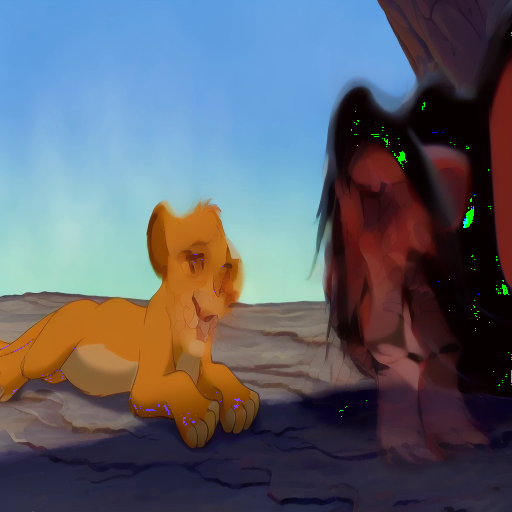

In [165]:
lo

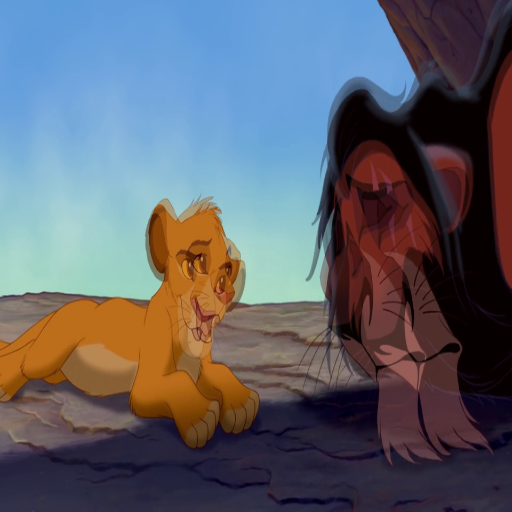

In [164]:
topil(uN(img.mean(0)))

In [9]:
!accelerator config

/bin/bash: accelerator: command not found


In [11]:

from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
pipeline = StableDiffusionPipeline.from_pretrained(
            "/home/junho/iso-diffusers/examples/text_to_image/output2/sd2-ffhq512-79/"
        )

OSError: Error no file named model_index.json found in directory /home/junho/iso-diffusers/examples/text_to_image/output2/sd2-ffhq512-79/.

In [ ]:
# Load from my checkpoint/unet
model_path = "output/sd2-ffhq512-43"
model_name = "lambdalabs/miniSD-diffusers"
unet = UNet2DConditionModel.from_pretrained(model_path + "/checkpoint-320000/unet")

pipe = DiffusionPipeline.from_pretrained(
    model_name, 
    unet=unet, 
    #torch_dtype=torch.float16,
    safety_checker=None,
    custom_pipeline="interpolate_stable_diffusion",
).to("cuda")

In [14]:
unet = UNet2DConditionModel.from_pretrained(
    "/home/junho/iso-diffusers/examples/text_to_image/output2/sd2-ffhq512-79/checkpoint-50000/"
)

OSError: Error no file named config.json found in directory /home/junho/iso-diffusers/examples/text_to_image/output2/sd2-ffhq512-79/checkpoint-50000/.

In [5]:
import torch
from diffusers import EulerDiscreteScheduler, StableDiffusionPipeline, DiffusionPipeline, DDPMPipeline, UNet2DConditionModel
from stable_diffusion_videos import StableDiffusionWalkPipeline

# Pre-trained model
pipe = DiffusionPipeline.from_pretrained(
    "/home/junho/iso-diffusers/examples/text_to_image/output2/sd2-ffhq512-79/checkpoint-50000",
    # revision='fp16',
    # torch_dtype=torch.float16,
    safety_checker=None,  # Very important for videos...lots of false positives while interpolating
    custom_pipeline="interpolate_stable_diffusion",
).to('cuda')
pipe.enable_attention_slicing()

OSError: Error no file named model_index.json found in directory /home/junho/iso-diffusers/examples/text_to_image/output2/sd2-ffhq512-79/checkpoint-50000.

In [14]:
weight_dtype=torch.float32
text_encoder.to(accelerator.device, dtype=weight_dtype)
print()

In [15]:
accelerator.device

device(type='cpu')

In [13]:
accelerator.unwrap_model(text_encoder).device

device(type='cpu')

In [2]:
pipeline = StableDiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2",
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        unet=unet,
        safety_checker=None,
        revision=None,
        torch_dtype=torch.float32,
    )

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [45]:
vae.post_quant_conv.weight.dtype

torch.float32

In [19]:
import numpy as np
t1=np.asarray(['asdfasdfasdf', 'sdfds sdfsdf ssdfsdfsdf', 'sdgasdga sdfadsgweqtwgdfbvx fdbsdfg', ' sadgxvcxbdfhasdfw dv sa xwe fsda fssaea a'])
t2=np.asarray(['wqet', 'qwetdsgc sfas sas dacxva', 'sadgasdgadsf', 'asdfadsfa'])
def embed(text, pipeline):
    text_input = pipeline.tokenizer(
        list(text),
        padding="max_length",
        max_length=pipeline.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    with torch.no_grad():
        embed = text_encoder(text_input.input_ids)[0]
    return embed
e1 = embed(t1,pipeline)
e2 = embed(t2,pipeline)

In [45]:
def add_dimensions(x, n_additional_dims):
    for _ in range(n_additional_dims):
        x = x.unsqueeze(-1)
    return x
t = torch.rand(4, dtype=torch.float16)
t = add_dimensions(t, 3)

In [51]:
e1.shape

torch.Size([4, 77, 1024])

In [52]:
torch.lerp(e1.unsqueeze(1), e2.unsqueeze(1), t.float()).shape

torch.Size([4, 1, 77, 1024])

In [85]:
z0 = torch.randn([4, 4, 32, 32])
z1 = torch.randn([4, 4, 32, 32])
et0 = torch.lerp(e1.unsqueeze(1), e2.unsqueeze(1), t.float()).squeeze(1)
et1 = torch.lerp(e1.unsqueeze(1), e2.unsqueeze(1), t.float() + 1e-2).squeeze(1)
zt0 = torch.lerp(z0, z1, t.float())
zt1 = torch.lerp(z0, z1, t.float() + 1e-2)

In [76]:
zt0.shape

torch.Size([4, 4, 32, 32])

In [77]:
et0.shape

torch.Size([4, 77, 1024])

In [56]:
gen = torch.Generator(device='cpu')

In [83]:
pipeline.unet.in_channels

/tmp/ipykernel_75714/1549683917.py:1: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  pipeline.unet.in_channels


4

In [82]:
pipeline.unet.sample_size

96

In [86]:
pipeline.vae.decoder(zt0)

tensor([[[[ 0.0087, -0.0706, -0.0516,  ..., -0.0997,  0.0043, -0.1362],
          [-0.1111, -0.0520,  0.1678,  ..., -0.1733, -0.1638, -0.1679],
          [-0.0506,  0.0042, -0.2724,  ..., -0.0681, -0.2478, -0.0571],
          ...,
          [ 0.0924,  0.2228,  0.2411,  ...,  0.0505,  0.0598,  0.0155],
          [ 0.0598,  0.0916,  0.1169,  ...,  0.0318,  0.0448, -0.0242],
          [ 0.1019,  0.1287,  0.0571,  ...,  0.0519,  0.0274, -0.0466]],

         [[-0.0251, -0.1223, -0.0995,  ..., -0.1770, -0.0261, -0.2035],
          [-0.1482, -0.0652,  0.2063,  ..., -0.2295, -0.2009, -0.2219],
          [-0.0697,  0.0109, -0.2599,  ..., -0.0936, -0.2790, -0.0911],
          ...,
          [ 0.0352,  0.2389,  0.2541,  ..., -0.1172, -0.0864, -0.0976],
          [ 0.0092,  0.0635,  0.0900,  ..., -0.1206, -0.1086, -0.1542],
          [ 0.0478,  0.0908,  0.0222,  ..., -0.0905, -0.1130, -0.1633]],

         [[-0.0855, -0.1824, -0.1764,  ..., -0.2997, -0.2063, -0.3097],
          [-0.1874, -0.1301,  

In [74]:
pipeline.unet(zt0, torch.tensor([1,2,3,4]), None)

RuntimeError: Given groups=1, weight of size [320, 4, 3, 3], expected input[4, 3, 64, 64] to have 4 channels, but got 3 channels instead

In [32]:
t.shape

torch.Size([4])

In [13]:
device = 'cpu'
sampling_shape = [32, 3, 224, 224]
z0 = torch.randn(sampling_shape, device=device)
z1 = torch.randn(sampling_shape, device=device)
t = torch.rand(sampling_shape[0], device=device)
t = add_dimensions(t, 3)

In [15]:
slerp(t, z0, z1).shape

True


torch.Size([32, 3, 224, 224])

In [3]:
ckpt = torch.load("diffusion_pytorch_model.bin", map_location=torch.device('cpu'))

In [2]:
import torch
from diffusers import DiffusionPipeline, DDPMPipeline, UNet2DConditionModel

# Load from my checkpoint/unet
model_path = "output/sd2-ffhq512-3"
model_name = "stabilityai/stable-diffusion-2"
unet = UNet2DConditionModel.from_pretrained(model_path + "/checkpoint-69000/unet")
pipe = DiffusionPipeline.from_pretrained(
    model_name, 
    unet=unet, 
    #torch_dtype=torch.float16,
    safety_checker=None,
    custom_pipeline="interpolate_stable_diffusion",
)

OSError: We couldn't connect to 'https://huggingface.co' to load this model, couldn't find it in the cached files and it looks like output/sd2-ffhq512-3/checkpoint-69000/unet is not the path to a directory containing a config.json file.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/diffusers/installation#offline-mode'.

export MODEL_NAME="stabilityai/stable-diffusion-2" #"CompVis/stable-diffusion-v1-4"
export DATASET_NAME="Ryan-sjtu/ffhq512-caption" #"facebook/winoground" #"lambdalabs/pokemon-blip-captions"

accelerate launch --mixed_precision="fp16"  train_text_to_image.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$DATASET_NAME \
  --use_ema \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=4 \
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --max_train_steps=70000 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --lr_scheduler="constant" --lr_warmup_steps=0 \
  --output_dir="output/sd2-ffhq512-8" \
  --validation_epochs=1 \
  --validation_prompts "a photography of a happy baby" "a photography of a woman smiling" \
  --prompts_reps=8 \
  --image_column="image" \
  --caption_column="text" \
  --split="train" \
  --prediction_type="epsilon" \
  --lambda_pl=1 \


In [1]:
from datasets import load_dataset
dataset_name = "Ryan-sjtu/ffhq512-caption"
dataset = load_dataset(
            dataset_name,
            None,
            cache_dir=None,
            use_auth_token=True
        )

Found cached dataset parquet (/home/junho/.cache/huggingface/datasets/Ryan-sjtu___parquet/Ryan-sjtu--ffhq512-caption-168cfb2a7611a8ef/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
dataset['train']['text']

Dataset({
    features: ['image', 'text'],
    num_rows: 70000
})

In [1]:
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.state import AcceleratorState
from accelerate.utils import ProjectConfiguration, set_seed
accelerator = Accelerator(
        gradient_accumulation_steps=1,
        mixed_precision="fp16"
    )

In [17]:
accelerator

AttributeError: 'Accelerator' object has no attribute 'keys'

In [3]:
import os

os.chdir("examples/text_to_image")

/home/junho/projects/junho/iso-diffusers


In [9]:

import argparse
import torch
import numpy as np
import pickle
from datasets import load_dataset
import random
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer
from accelerate.state import AcceleratorState
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration
from dnnlib.util import open_url
import torch_utils

parser = argparse.ArgumentParser()
parser.add_argument('--path', type=str, default="Ryan-sjtu/ffhq512-caption")
parser.add_argument('--pretrained_model_name_or_path', type=str, default="stabilityai/stable-diffusion-2")
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--resolution', type=int, default=256)
parser.add_argument('--center_crop', type=bool, default=True)
parser.add_argument('--random_flip', type=bool, default=True)
parser.add_argument('--fid_dir', type=str, default='./')
parser.add_argument('--split', type=str, default='train')
parser.add_argument('--file', type=str, default="ffhq.npz")
parser.add_argument('--max_samples', type=int, default=20)

args = parser.parse_args("")

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
pre_dataset = load_dataset(
            args.path,
            None,
            cache_dir=None,
            use_auth_token=True
        )
column_names = pre_dataset[args.split].column_names # "train"

DATASET_NAME_MAPPING = {
"lambdalabs/pokemon-blip-captions": ("image", "text"),
}

# 6. Get the column names for input/target.
dataset_columns = DATASET_NAME_MAPPING.get(args.path, None)

image_column = dataset_columns[0] if dataset_columns is not None else column_names[0]

caption_column = dataset_columns[1] if dataset_columns is not None else column_names[1]

tokenizer = CLIPTokenizer.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="tokenizer", revision=None
)
# Preprocessing the datasets.
# We need to tokenize input captions and transform the images.
def tokenize_captions(examples, is_train=True):
    captions = []
    for caption in examples[caption_column]:
        if isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])
        else:
            raise ValueError(
                f"Caption column `{caption_column}` should contain either strings or lists of strings."
            )
    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
    return inputs.input_ids

# Preprocessing the datasets.
train_transforms = transforms.Compose(
    [
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
        transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def preprocess_train(examples):
    images = [image.convert("RGB") for image in examples[image_column]]
    examples["pixel_values"] = [train_transforms(image) for image in images]
    examples["input_ids"] = tokenize_captions(examples)
    return examples
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# dataset = ImageFolderDataset(args.path)
dataset = pre_dataset[args.split].with_transform(preprocess_train)
# queue = torch.utils.data.DataLoader(dataset=dataset, batch_size=args.batch_size, pin_memory=True, num_workers=0)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example["input_ids"] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids}

queue  = torch.utils.data.DataLoader(
    dataset,
    shuffle=False,
    collate_fn=collate_fn,
    batch_size=args.batch_size,
    num_workers=0,
)
with open_url('https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/metrics/inception-2015-12-05.pkl') as f:
    model = pickle.load(f).to(device)
    model.eval()
# accelerator_project_config = ProjectConfiguration(project_dir="output/sd2-ffhq512-8", logging_dir="logs")
# accelerator = Accelerator(
#     gradient_accumulation_steps=1,
#     mixed_precision="fp16",
#     project_config=accelerator_project_config,
# )
# queue = accelerator.prepare(queue)

Found cached dataset parquet (/home/junho/.cache/huggingface/datasets/Ryan-sjtu___parquet/Ryan-sjtu--ffhq512-caption-168cfb2a7611a8ef/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

In [67]:
def get_activations(dl, model, batch_size, device, max_samples, include_step=True):
    pred_arr = []
    total_processed = 0

    print('Starting to sample.')
    if include_step:
        for step, batch in enumerate(dl):
            batch = batch["pixel_values"].to(torch.float16)
            # ignore labels
            if isinstance(batch, list):
                batch = batch[0]

            batch = batch.to(device)
            if batch.shape[1] == 1:  # if image is gray scale
                batch = batch.repeat(1, 3, 1, 1)
            elif len(batch.shape) == 3:  # if image is gray scale
                batch = batch.unsqueeze(1).repeat(1, 3, 1, 1)


            with torch.no_grad():
                pred = model(batch, return_features=True).unsqueeze(-1).unsqueeze(-1)

            pred = pred.squeeze(3).squeeze(2).cpu().numpy()
            pred_arr.append(pred)
            total_processed += pred.shape[0]
            if max_samples is not None and total_processed > max_samples:
                print('Max of %d samples reached.' % max_samples)
                break
        pred_arr = np.concatenate(pred_arr, axis=0)
        if max_samples is not None:
            pred_arr = pred_arr[:max_samples]
    else:
        for batch in dl:
            # ignore labels
            if isinstance(batch, list):
                batch = batch[0]

            batch = batch.to(device)
            if batch.shape[1] == 1:  # if image is gray scale
                batch = batch.repeat(1, 3, 1, 1)
            elif len(batch.shape) == 3:  # if image is gray scale
                batch = batch.unsqueeze(1).repeat(1, 3, 1, 1)


            with torch.no_grad():
                pred = model(batch, return_features=True).unsqueeze(-1).unsqueeze(-1)

            pred = pred.squeeze(3).squeeze(2).cpu().numpy()
            pred_arr.append(pred)
            total_processed += pred.shape[0]
            if max_samples is not None and total_processed > max_samples:
                print('Max of %d samples reached.' % max_samples)
                break

        pred_arr = np.concatenate(pred_arr, axis=0)
        if max_samples is not None:
            pred_arr = pred_arr[:max_samples]

    return pred_arr


In [61]:
act = get_activations(queue, model, batch_size=args.batch_size, device=device, max_samples=20)
mu = np.mean(act, axis=0)
sigma = np.cov(act, rowvar=False)
file_path = os.path.join(args.fid_dir, args.file)
np.savez(file_path, mu=mu, sigma=sigma)

Starting to sample.
Max of 20 samples reached.


In [60]:
act = get_activations(queue, model, batch_size=args.batch_size, device=device, max_samples=args.max_samples)

Starting to sample.
Max of 20 samples reached.


In [43]:
for step, batch in enumerate(queue):
    break
batch = batch["pixel_values"].to(torch.float16)

In [52]:
batch.min()

tensor(-1., dtype=torch.float16)

In [ ]:
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
StableDiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        vae=accelerator.unwrap_model(vae),
        text_encoder=accelerator.unwrap_model(text_encoder),
        tokenizer=tokenizer,
        unet=accelerator.unwrap_model(unet),
        safety_checker=None,
        revision=args.revision,
        torch_dtype=weight_dtype,
    )

In [1]:
import dnnlib
import pickle
def open_file_or_url(file_or_url):
    if dnnlib.util.is_url(file_or_url):
        return dnnlib.util.open_url(file_or_url, cache_dir='.stylegan2-cache')
    return open(file_or_url, 'rb')
def load_pkl(file_or_url):
    with open_file_or_url(file_or_url) as file:
        return pickle.load(file, encoding='latin1')


In [1]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex')

In [5]:
lpips.net()

TypeError: _LPIPS.forward() missing 2 required positional arguments: 'in0' and 'in1'

In [2]:
from dnnlib.util import open_url
import pickle
with open_url('https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/metrics/inception-2015-12-05.pkl') as f:
    inception_model = pickle.load(f)
    inception_model.eval()

In [17]:
from datasets import load_dataset
dataset = load_dataset(
            "ChristophSchuhmann/improved_aesthetics_6plus",
            None,
            cache_dir=None,
            use_auth_token=True
        )

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/12096828 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /home/junho/.cache/huggingface/datasets/ChristophSchuhmann___parquet/ChristophSchuhmann--improved_aesthetics_6plus-7c2167cd9924b81c/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]